In [3]:
#potential ml on the site duration plot
import sys
sys.path.append('../../../src/')

import os
from typing import Dict
from os import PathLike
from pathlib import Path
import csv 

from aind_vr_foraging_analysis import utils
from aind_vr_foraging_analysis.utils import parse, processing, plotting_utils as plotting, AddExtraColumns

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages

import seaborn as sns
import pandas as pd
import numpy as np
import datetime

sns.set_context('talk')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import ipywidgets as widgets
from IPython.display import display
from matplotlib.patches import Rectangle
from scipy.signal import find_peaks, butter, lfilter


colors = sns.color_palette()
odor_list_color = [colors[8], colors[0], colors[2], colors[4]]

pdf_path = r'/Volumes\scratch\vr-foraging\sessions'
base_path = r'/Volumes/scratch/vr-foraging/data/'
foraging_figures = r'/Users/nehal.ajmal/Documents/aindproject/analysis_files'

from scipy.optimize import curve_fit

In [2]:
#exploring at work
session_path = r'/Volumes/aind/scratch/vr-foraging/data/717717/717717_20240802T091009'

#get mouse_id from first 6 numbers in file name
mouse = session_path.split('/')[-1][:6]

#get session from first 8 numbers after mouse_id
session = session_path.split('/')[-1][6:15]

In [3]:
session_path = Path(session_path)
data = parse.load_session_data(session_path)

# Parse data into a dataframe with the main features
reward_sites, active_site, config = parse.parse_dataframe(data)


In [4]:
# Expand with extra columns
reward_sites = AddExtraColumns(reward_sites, active_site, run_on_init=True).reward_sites
 # Add extra columns to the active_site dataframe
active_site = AddExtraColumns(reward_sites, active_site, run_on_init=False).add_time_previous_intersite_interpatch()

In [5]:
# Recover color palette
color_dict_label = {}
dict_odor = {}
list_patches = parse.TaskSchemaProperties(data).patches
for i, patches in enumerate(list_patches):
    color_dict_label[patches['label']] = odor_list_color[i]
    dict_odor[i] = patches['label']

In [6]:
# Load the encoder data separately
stream_data = parse.ContinuousData(data)
encoder_data = stream_data.encoder_data

In [7]:
def plot_duration_by_site(data, x_col, y_col, hue_col, hue_order, palette, x_label, y_label, title, bbox_to_anchor=(1.05, 1), loc=2):
    """
    Plot duration of each reward site with the trial type / odor_label in color.

    Parameters:
    - data: DataFrame containing the data to plot.
    - x_col: The name of the column for the x-axis.
    - y_col: The name of the column for the y-axis.
    - hue_col: The name of the column for the hue.
    - hue_order: List of hue categories to order.
    - palette: Color palette for the plot.
    - x_label: Label for the x-axis.
    - y_label: Label for the y-axis.
    - title: Title of the plot.
    - bbox_to_anchor: Position of the legend.
    - loc: Location of the legend.
    """
    fig, ax = plt.subplots()
    ax = sns.scatterplot(data=data, x=x_col, y=y_col, hue=hue_col, hue_order=hue_order, ax=ax, palette=palette)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.legend(bbox_to_anchor=bbox_to_anchor, loc=loc)
    plt.show()

In [8]:
active_site['next_intersite'] = active_site.index.to_series().shift(-1)
reward_sites = active_site.loc[active_site['label']=='RewardSite']
reward_sites['time_in_odor_site'] = reward_sites.next_intersite - reward_sites.index

#make plot_df 
plot_df = reward_sites[['time_in_odor_site', 'odor_label', 'active_patch']]
plot_df = plot_df[plot_df['time_in_odor_site'] < 10]

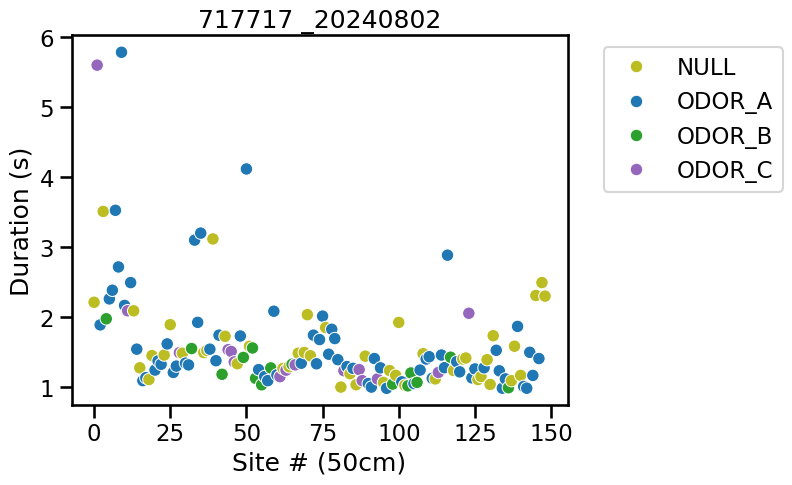

In [9]:
# plot duration of each reward site, with the trial type / odor_label in color
plot_duration_by_site(
    data=plot_df,
    x_col='active_patch',
    y_col='time_in_odor_site',
    hue_col='odor_label',
    hue_order=np.sort(plot_df['odor_label'].unique()),
    palette=odor_list_color,
    x_label='Site # (50cm)',
    y_label='Duration (s)',
    title=f'{mouse} {session}'
)

In [4]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# List of specific folder names you want to process
specific_folders = [
    '745306', '745305', '745301', '745300', '717717', '717716'
]

base_directory_path = '/Volumes/aind/scratch/vr-foraging/data'

# Function to process a single session path
def process_session_path(session_path):
    try:
        mouse = session_path.split('/')[-1][:6]
        session = session_path.split('/')[-1][6:15]
        session_path = Path(session_path)
        data = parse.load_session_data(session_path)

        # Parse data into a dataframe with the main features
        reward_sites, active_site, config = parse.parse_dataframe(data)

        # Expand with extra columns
        reward_sites = AddExtraColumns(reward_sites, active_site, run_on_init=True).reward_sites
        active_site = AddExtraColumns(reward_sites, active_site, run_on_init=False).add_time_previous_intersite_interpatch()

        # Prepare the reward_sites DataFrame
        active_site['next_intersite'] = active_site.index.to_series().shift(-1)
        reward_sites = active_site.loc[active_site['label'] == 'RewardSite']
        reward_sites['time_in_odor_site'] = reward_sites.next_intersite - reward_sites.index

        # Create plot_df
        plot_df = reward_sites[['time_in_odor_site', 'odor_label', 'active_patch']]
        plot_df = plot_df[plot_df['time_in_odor_site'] < 10]

        return plot_df
    except Exception as e:
        print(f"Error processing session at {session_path}: {e}")
        return pd.DataFrame()  # Return an empty DataFrame on error

# Function to collect data from specific folders in the directory
def collect_data_from_specific_folders(base_directory_path, folder_names):
    all_plot_df = pd.DataFrame()
    try:
        for folder_name in folder_names:
            folder_path = os.path.join(base_directory_path, folder_name)
            if os.path.isdir(folder_path):
                session_paths = [os.path.join(folder_path, sub_folder) for sub_folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, sub_folder))]
                for path in session_paths:
                    session_plot_df = process_session_path(path)
                    if not session_plot_df.empty:
                        all_plot_df = pd.concat([all_plot_df, session_plot_df], ignore_index=True)
            else:
                print(f"Folder {folder_name} does not exist in {base_directory_path}")
    except Exception as e:
        print(f"Error collecting data from directory {base_directory_path}: {e}")
    
    return all_plot_df


Error processing session at /Volumes/aind/scratch/vr-foraging/data/745305/745305_20240710T120912: Path /Volumes/aind/scratch/vr-foraging/data/745305/745305_20240710T120912/behavior/SoftwareEvents is not a directory
Error processing session at /Volumes/aind/scratch/vr-foraging/data/745305/745305_20240711T113208: "None of ['Seconds'] are in the columns"
No reward sites found
Error processing session at /Volumes/aind/scratch/vr-foraging/data/745305/745305_20240715T152306: 'reward_delivered'
No reward sites found
Error processing session at /Volumes/aind/scratch/vr-foraging/data/745305/745305_20240716T162026: 'reward_delivered'
No reward sites found
Error processing session at /Volumes/aind/scratch/vr-foraging/data/745305/745305_20240717T153644: 'reward_delivered'
Error processing session at /Volumes/aind/scratch/vr-foraging/data/745305/745305_20240719T102443: "None of ['Seconds'] are in the columns"
Error processing session at /Volumes/aind/scratch/vr-foraging/data/745305/745305_20240723T

NameError: name 'X_resampled' is not defined

In [ ]:
# # Collect data from the specified folders
all_plot_df = collect_data_from_specific_folders(base_directory_path, specific_folders)

Accuracy: 0.28
              precision    recall  f1-score   support

        NULL       0.61      0.29      0.40       543
      ODOR_A       0.30      0.23      0.26       289
      ODOR_B       0.06      0.33      0.10        46
      ODOR_C       0.06      0.42      0.10        24

    accuracy                           0.28       902
   macro avg       0.26      0.32      0.21       902
weighted avg       0.47      0.28      0.33       902

Confusion Matrix:
[[158 137 147 101]
 [ 79  67  84  59]
 [ 14  10  15   7]
 [  6   6   2  10]]


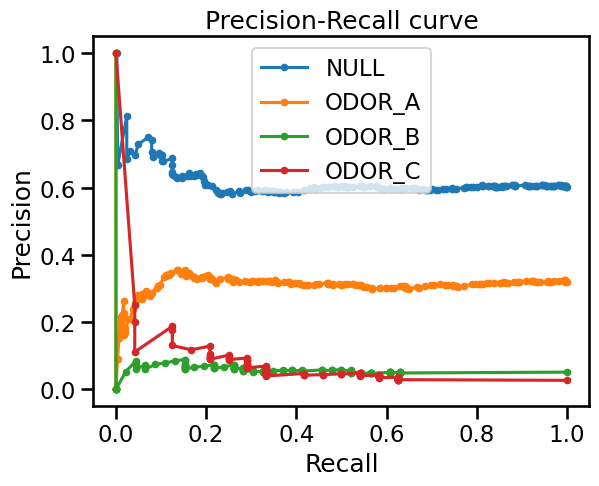

Cross-Validation Scores: [0.28159645 0.32039911 0.28603104 0.28713969 0.32594235]
Mean CV Accuracy: 0.30
Standard Deviation of CV Accuracy: 0.02
  Actual Label Predicted Label
0         NULL            NULL
1         NULL            NULL
2         NULL            NULL
3         NULL          ODOR_C
4         NULL            NULL


In [6]:

# Initialize LabelEncoders
active_patch_encoder = LabelEncoder()
odor_label_encoder = LabelEncoder()

# Fit encoders
active_patch_encoder.fit(all_plot_df['active_patch'])
odor_label_encoder.fit(all_plot_df['odor_label'])

# Encode labels using fitted encoders
all_plot_df['active_patch_encoded'] = active_patch_encoder.transform(all_plot_df['active_patch'])
all_plot_df['odor_label_encoded'] = odor_label_encoder.transform(all_plot_df['odor_label'])

# Define features and target for training
X = all_plot_df[['active_patch_encoded']]
y = all_plot_df['odor_label_encoded']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Define hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

# Train the model
best_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print classification report
target_names = odor_label_encoder.classes_
print(classification_report(y_test, y_pred, target_names=target_names))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Precision-Recall Curve (for each class if applicable)
for i, class_label in enumerate(target_names):
    precision, recall, _ = precision_recall_curve(y_test == i, best_model.predict_proba(X_test)[:, i])
    plt.plot(recall, precision, marker='.', label=class_label)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()

# Cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=5)  # 5-fold cross-validation
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {np.mean(cv_scores):.2f}')
print(f'Standard Deviation of CV Accuracy: {np.std(cv_scores):.2f}')

# Make predictions on the entire dataset (optional)
predictions = best_model.predict(X)
predicted_labels = odor_label_encoder.inverse_transform(predictions)

# Map actual labels back to original labels
actual_labels = odor_label_encoder.inverse_transform(y)

# Create a DataFrame to compare actual vs predicted labels
results_df = pd.DataFrame({
    'Actual Label': actual_labels,
    'Predicted Label': predicted_labels
})

# Print results
print(results_df.head())

In [25]:
import csv

#read in all_plot_df
all_plot_df = pd.read_csv(r'/Users/nehal.ajmal/Documents/aindproject/ml/all_plot_df.csv')





In [26]:

all_plot_df

,Unnamed: 0.7,Unnamed: 0.6,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,time_in_odor_site,odor_label,active_patch,active_patch_encoded,odor_label_encoded
0,0,0,0,0,0,0,0,0,9.733024,NaN,1.0,0,0
1,1,1,1,1,1,1,1,1,9.900000,NaN,4.0,1,0
2,2,2,2,2,2,2,2,2,9.344992,NaN,4.0,1,0
3,3,3,3,3,3,3,3,3,9.967008,NaN,6.0,2,0
4,4,4,4,4,4,4,4,4,9.277024,NaN,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4505,4505,4505,4505,4505,4505,4505,4505,4505,1.083008,NaN,69.0,69,0
4506,4506,4506,4506,4506,4506,4506,4506,4506,0.951008,NaN,70.0,70,0
4507,4507,4507,4507,4507,4507,4507,4507,4507,1.367008,ODOR_A,71.0,71,1
4508,4508,4508,4508,4508,4508,4508,4508,4508,2.175008,ODOR_A,72.0,72,1
